In [ ]:
!pip install -U albumentations>=0.3.0 
!pip install -U segmentation-models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from zipfile import ZipFile

zipContent = ZipFile('./content') 
zipContent.extractall('./')
zipContent.close()

# Defining each part of dataset

*   train images + segmentation masks
*   validation images + segmentation masks
*   test images + segmentation masks

All images have 512 pixels height and 512 pixels width.




In [1]:
import sys
sys.path.insert(1, './modules')

In [17]:
import constants
import dataset as ds
import dataloader as dl
import utility
import augmentation

In [18]:
x_train_dir = constants.TRAIN_DIR
y_train_dir = constants.TRAIN_ANNOTATION_DIR

x_valid_dir = constants.VAL_DIR 
y_valid_dir = constants.VAL_ANNOTATION_DIR

x_test_dir = constants.TEST_DIR
y_test_dir = constants.TEST_ANNOTATION_DIR

In [19]:
util = utility.Utility

In [20]:
aug = augmentation.Augmentation()

In [21]:
dataset = ds.Dataset(
    x_train_dir,
    y_train_dir,
    classes=['layer_1'],
    augmentation=aug.get_training_augmentation()
)

In [24]:

img, mask = dataset[0]

In [26]:
print(img.shape)
print(mask.shape)

(512, 512, 3)
(512, 512, 3, 1)


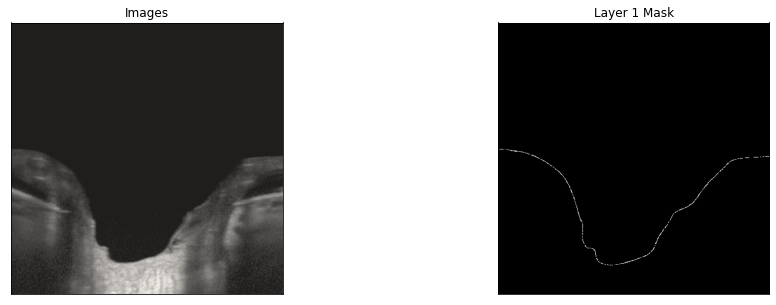

In [19]:
image, mask = dataset[1]

util.visualize(
    images=image,
    layer_1_mask=mask[..., 0].squeeze()
)

In [23]:
import segmentation_models as sm

sm.set_framework('tf.keras')

BACKBONE = 'resnet34'
BATCH_SIZE = 8
CLASSES = ['layer_1']
LR = 0.0001
EPOCHS = 40

preprocess_input = sm.get_preprocessing(BACKBONE)

In [24]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

44122112/44107200 [==============================] - 1s 0us/step


In [27]:
import tensorflow as tf

# define optomizer
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [40]:
# Dataset for train images
train_dataset = ds.Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=aug.get_training_augmentation(),
    preprocessing=aug.get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = ds.Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=aug.get_validation_augmentation(),
    preprocessing=aug.get_preprocessing(preprocess_input),
)

train_dataloader = dl.Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = dl.Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
# assert train_dataloader[0][0].shape == (BATCH_SIZE, 512, 512, 3)
# assert train_dataloader[0][1].shape == (BATCH_SIZE, 512, 512, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(),
]

In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)